In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN:  ______________________
- Date: ______________________

# Image Processing with Neural Network
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [1]:
###-----------------
### Import Libraries
###-----------------
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from flatbuffers.packer import int16
from keras.src.applications.densenet import DenseNet169
#from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_labels
from sklearn.metrics import classification_report,accuracy_score,f1_score
from tensorflow.keras.applications import DenseNet169
    
%matplotlib inline

In [2]:
def fn_plot_labels(tr_ds, ts_ds, class_names = None):

    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
            class_names : Class names
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))

    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)

    # add title
    ax.set_title('Training Set')

    # grids make it look good
    ax.grid(True)


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)

    # add title
    ax.set_title('Test Set')


    # grids make it look good
    ax.grid(True)

    # fit the subplot(s) in to the figure area
    plt.tight_layout()

    # display all open figures
    plt.show()


In [3]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [4]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'students_base_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TEST_SIZE = 0.2
IMG_HEIGHT = 190
IMG_WIDTH = 190

# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1) 
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [5]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print (physical_devices)
else:
    print ('Error: No GPU device found')

Error: No GPU device found


## Helper Functions
**Note** all helper functions have been moved to util.helper

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [6]:
'''
    For reading from web link
'''

import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
# data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = "C:/Users/dai/PycharmProjects/PythonLab/Deep_Nueral_Networks/Assignment 7/flower_photos"

In [8]:
data_dir

'C:/Users/dai/PycharmProjects/PythonLab/Deep_Nueral_Networks/Assignment 7/flower_photos'

In [9]:
# list content of data_dir
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('total ', num_classes, class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


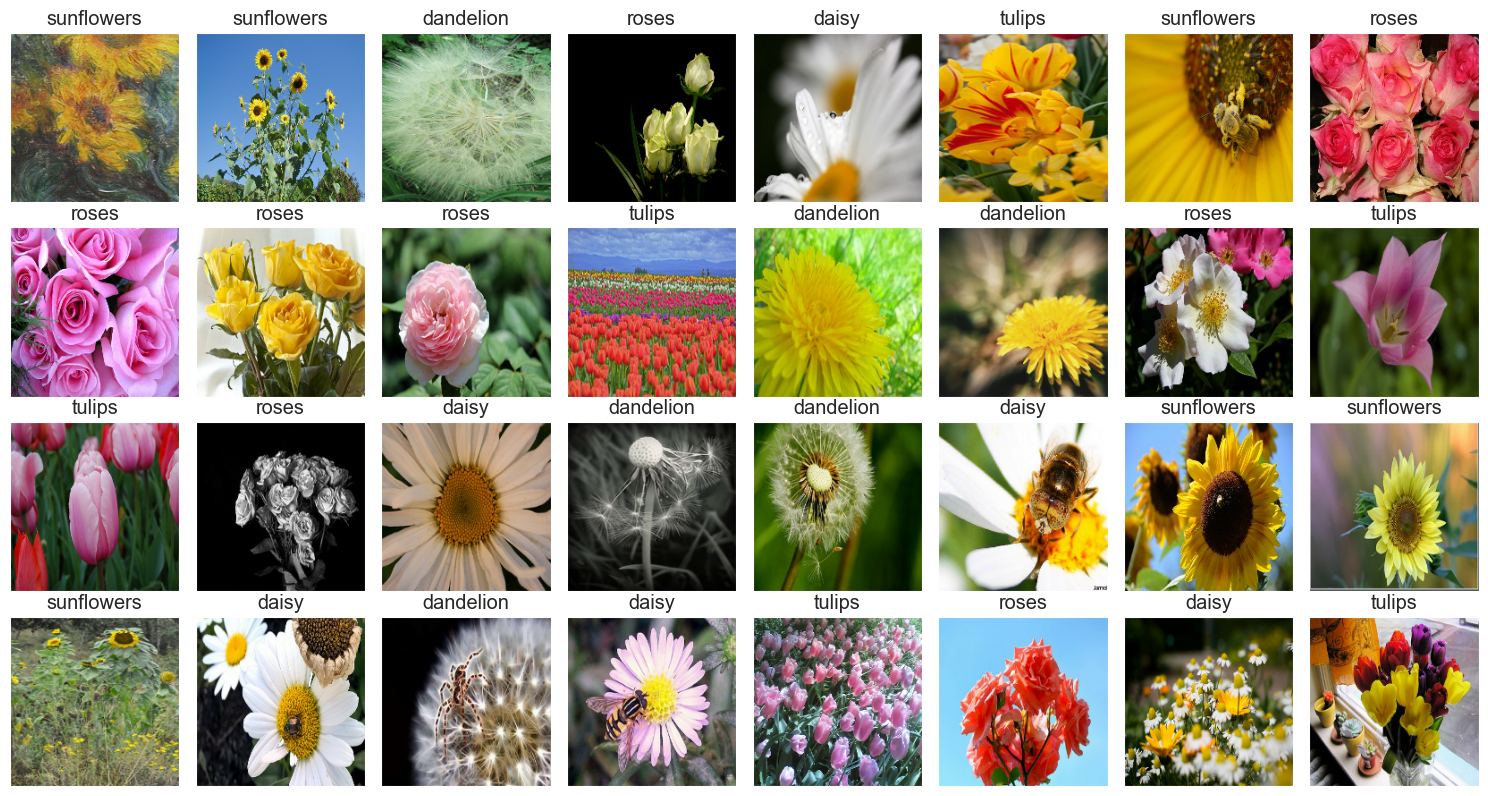

In [12]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        ax.set_title(class_names[labels[i]])
        
# fit the subplot(s) in to the figure area
plt.tight_layout()
    
# display all open images    
plt.show()

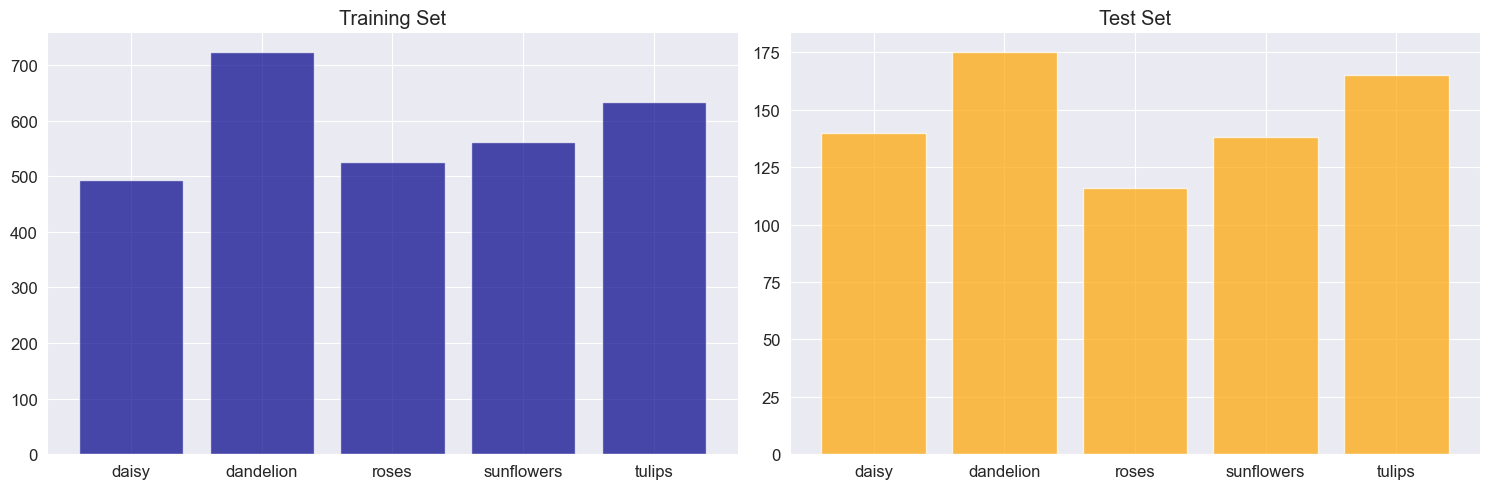

In [13]:
# how many examples in each of the class
fn_plot_labels(train_ds, test_ds)

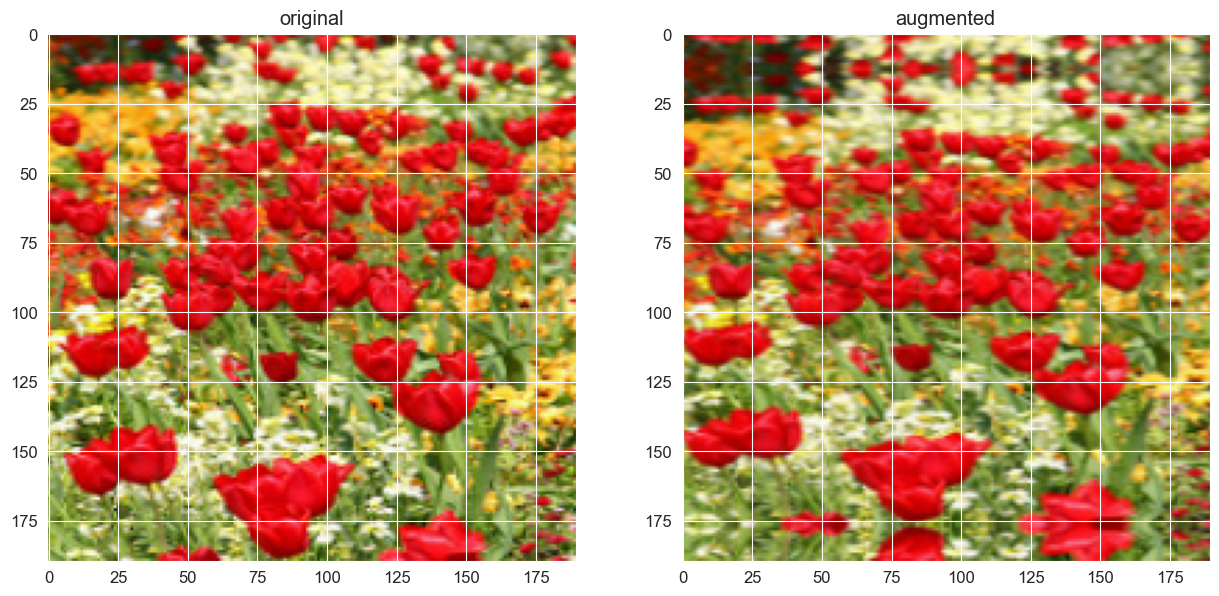

In [14]:
layer=tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2))
plt.figure()
img_num=0
for images,labels in train_ds:
    out_images=layer(images)
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(images[img_num].numpy().astype('uint16'))
plt.subplot(1,2,2)
plt.title("augmented")
plt.imshow(out_images[img_num].numpy().astype('uint16'))


In [9]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

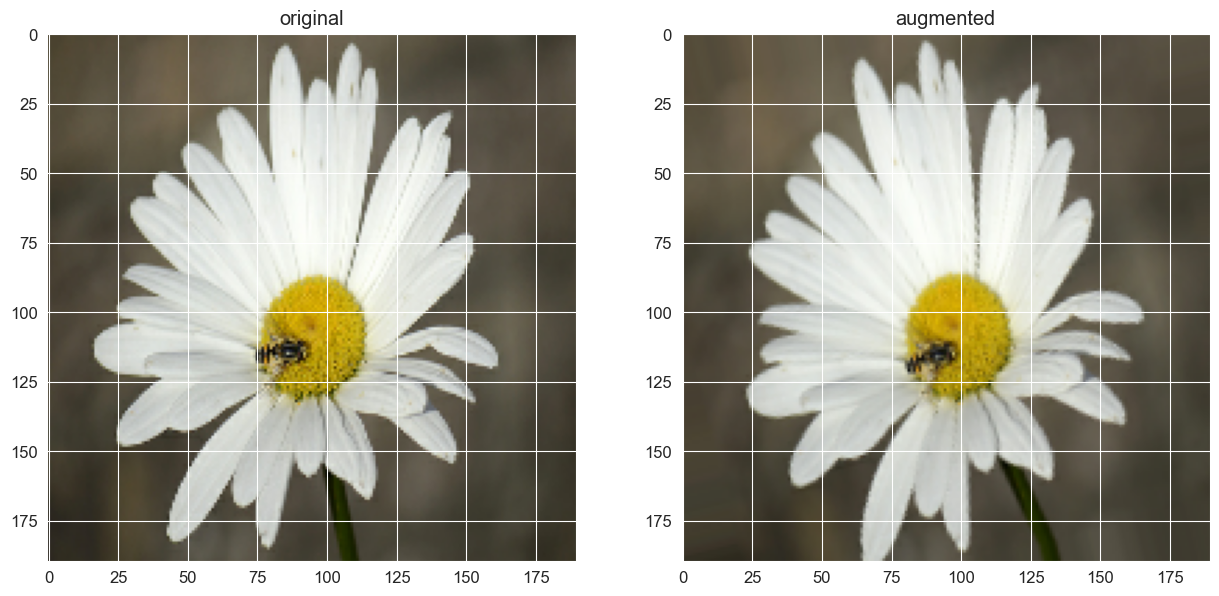

In [10]:
layer=tf.keras.layers.RandomRotation((-0.5,0.5),fill_mode="nearest")
plt.figure()
img_num=0
for images,labels in train_ds:
    out_images=layer(images)
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(images[img_num].numpy().astype('uint16'))
plt.subplot(1,2,2)
plt.title("augmented")
plt.imshow(out_images[img_num].numpy().astype('uint16'))


In [11]:
input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]

In [12]:
densenet_model=DenseNet169(weights='imagenet',include_top=False,input_shape=input_shape)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
for layer in densenet_model.layers:
    layer.trainable=False

In [14]:
densenet_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 190, 190,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 196, 196,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 95, 95,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 95, 95,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 95, 95,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 97, 97,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 48, 48,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 48,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 48, 48,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 48,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 48,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 48,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 48,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 48, 48,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 48, 48,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 48, 48,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 48, 48,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

In [15]:
def build_model(d_net, num_classes):
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255))
    model.add(d_net)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(num_classes))   #Classifier

    return model

In [16]:
model = build_model(densenet_model, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 6, 6, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

In [17]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA)
model.compile(optimizer=optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = ES_PATIENCE,
    verbose = 1,
    restore_best_weights = True,
    min_delta = 0
)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose = 1,
    min_lr = 1e-6,
)



In [19]:
hist=model.fit(train_ds,validation_data=test_ds,epochs=EPOCHS,callbacks=[es_callback,lr_callback])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7163 - loss: 0.7842 - val_accuracy: 0.8501 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8825 - loss: 0.3648 - val_accuracy: 0.8842 - val_loss: 0.3650 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9142 - loss: 0.2813 - val_accuracy: 0.8951 - val_loss: 0.3263 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9309 - loss: 0.2347 - val_accuracy: 0.9005 - val_loss: 0.3049 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9418 - loss: 0.2025 - val_accuracy: 0.8978 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9499 - loss: 0.1780 - val_accuracy: 0.9019 - val_loss: 0.2842 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9578 - loss: 0.1585 - 

In [20]:
y_test=tf.concat([y for x,y in test_ds],axis=0).numpy()
print('\nTest Shape:',y_test.shape)


Test Shape: (734,)


In [21]:


yhat=model.predict(test_ds)
y_pred=yhat.argmax(axis=1)
print(f'Accuracy:{accuracy_score(y_test,y_pred):.5f}')
print(classification_report(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))

23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
Accuracy:0.91144
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       140
           1       0.95      0.95      0.95       175
           2       0.85      0.91      0.88       116
           3       0.91      0.90      0.90       138
           4       0.90      0.90      0.90       165

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734

0.9088341658341659


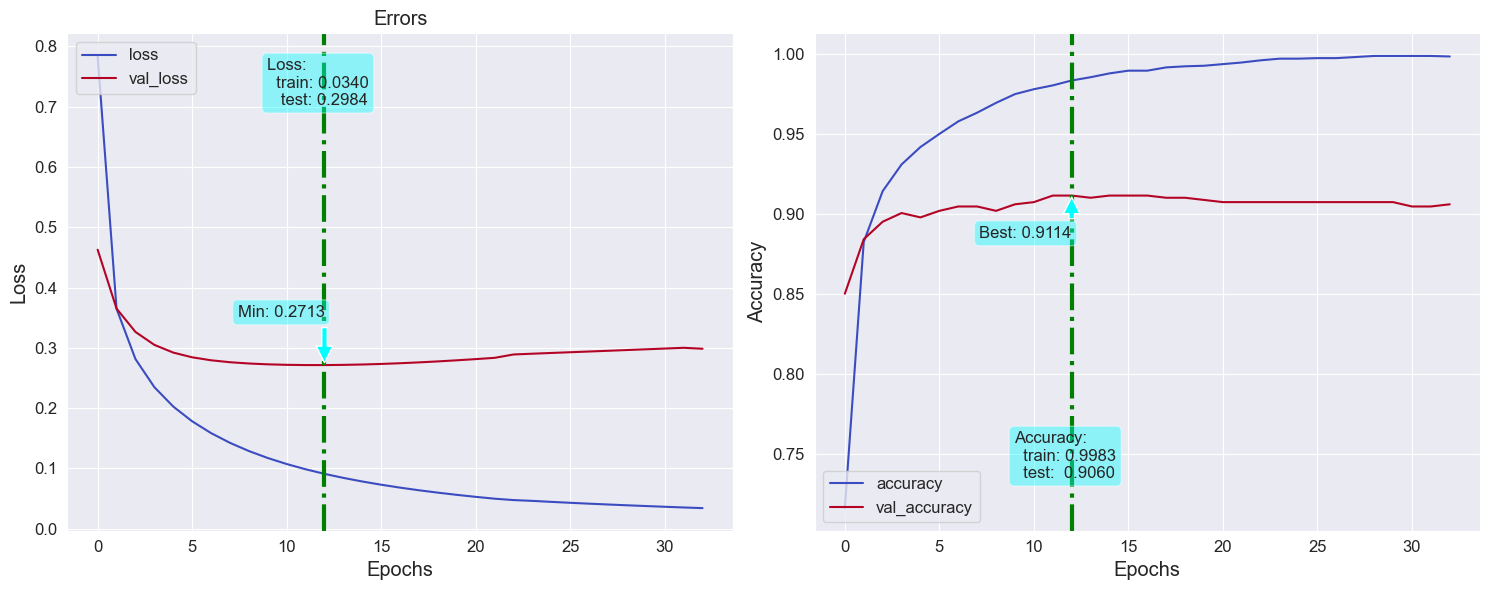

In [22]:
import pandas as pd
loss_df = pd.DataFrame(hist.history)
fn_plot_tf_hist(loss_df)

### Reload best Weights for evaluation

### Evaluate the model

## Validate on the validation set

In [26]:
data_dir = os.path.join(inpDir, valDir)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    #subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../input\\valid_flowers'

In [ ]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots
i = 0
# take one batch of the dataset
for images, labels in valid_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        ax.set_title(class_names[labels[i]])
        
# fit the subplot(s) in to the figure area
plt.tight_layout()
    
# display all open images    
plt.show()

In [ ]:
loss, acc = new_model.evaluate(valid_ds)

print('Accuracy score on Validation Data : {:.3f}%'.format( acc*100))

In [ ]:
for images, labels in valid_ds.take(2 ):
    
    # Predict again to keep y_pred in synch with the images
    yhat = new_model.predict(images, verbose = 0)
    
    y_pred = yhat.argmax(axis = 1)
    fontsize = 12
    fig = plt.figure()  # figure with default size in inches
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

    for i in range ( BATCH_SIZE ):
        
        if labels.numpy()[i]!= y_pred[i]:
            fc = 'purple'
            ec="red"
            text_color = 'yellow'
        else:
            fc = 'cyan'
            ec = 'blue'
            text_color = 'blue'

        props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec = ec)
        
        ax = fig.add_subplot(BATCH_SIZE // 8 , 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        ax.imshow ( images[i].numpy().astype( "uint8" ) )
        
        ax.text(0.1, 0.95, class_names[y_pred[i]], transform=ax.transAxes, 
                fontsize=fontsize, color = text_color,
            verticalalignment='top', bbox=props)   # add number (class) of the image

        
        ax.set_title(class_names[labels.numpy()[i]])
        #ax.set_title('{} \n {}'.format( class_names[labels.numpy()[i]], ))
        
        ax.axis("off")
        
    plt.tight_layout()
    
    plt.show()